In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

# PyTorch and Images

## Goals

- Know / Refresh the different components of a PyTorch ML Pipeline: Dataset, Data-Transforms, Data-Loader, Loss-Function, Logging & Metrics, Trainer, Evaluation
- Be able to read, visualize and inspect images.
- Train a neural network (MLP) on images

## Setup

Let's define paths, install & load the necessary Python packages.

**Optionally: Save the notebook to your personal google drive to persist changes.**

Mount your google drive to store data and results (if running the code in Google Colab).

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

**Modify the following paths if necessary.**

That is where your data will be stored.

In [4]:
from pathlib import Path

if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/bveri")
else:
    DATA_PATH = Path("/workspace/code/data")

Install the package `dl_cv_lectures`.

The following code installs the package from a local repository (if available), otherwise it installs it from the exercise repository.

In [5]:
try:
    import dl_cv_lectures

    print("dl_cv_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install .")
    else:
        print("Installing from git repo")
        os.system("pip install git+https://github.com/i4Ds/bveri-exercises-hs2024")

dl_cv_lectures installed, all good


### Load all packages

In [6]:
import io
import math
import random
from typing import Callable

import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torchshow as ts
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

Define a default device for your computations.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


## 1) Datasets: Define and Visualize

A dataset is a collection of observations (including labels) to train, evaluate or test a model.

Obtaining, organizing and defining datasets is an important step in data modeling. In the following, you will use PyTorch classes to create such datasets.

You can find more information in this tutorial:  [https://pytorch.org/tutorials/beginner/basics/data_tutorial.html](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In particular, you should be familiar with, understand, and be able to use the classes [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).


### Create a dataset from torchvision

We can easily pull / create a dataset from the [torchvision](https://pytorch.org/vision/stable/index.html) library. 

This package contains pre-packaged datasets which can be used for academic or testing purposes.

We download and create the `torchvision.datasets.MNIST` dataset.


In [8]:
ds_mnist_train = torchvision.datasets.MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:17<00:00, 551kB/s]


Extracting \workspace\code\data\MNIST\raw\train-images-idx3-ubyte.gz to \workspace\code\data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 253kB/s]


Extracting \workspace\code\data\MNIST\raw\train-labels-idx1-ubyte.gz to \workspace\code\data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:03<00:00, 495kB/s]


Extracting \workspace\code\data\MNIST\raw\t10k-images-idx3-ubyte.gz to \workspace\code\data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Extracting \workspace\code\data\MNIST\raw\t10k-labels-idx1-ubyte.gz to \workspace\code\data\MNIST\raw



Often, the ready-made datasets come already with train and test splits.

We also obtain the `test` split.

In [9]:
ds_mnist_test = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True)

### Look at individual observations

[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is either an iterable object or a map-style object (more common). The differences are described here [Link](https://pytorch.org/docs/stable/data.html#dataset-types).

Our MNIST dataset is a map-style dataset (`_ _ getitem _ _` method implemented). This means you can retrieve any item using its key or index. We can also inspect its size.



To access the first element of the dataset:

In [13]:
ds_mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

**Question**: What makes up an observation in this case?

**Question**: How many elements are in the dataset? Check with `len()`

Now we visualize the first observation. The dataset returns a  [PIL.Image](https://pillow.readthedocs.io/en/stable/reference/Image.html) object, which is the most commonly used representation for images in PyTorch.

In [85]:
pil_image, label = ds_mnist_train[0]
pil_image
print(f"Label: {label}")

Label: 5


We can also use [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) to visualize images. The most commonly used plotting library in Python:

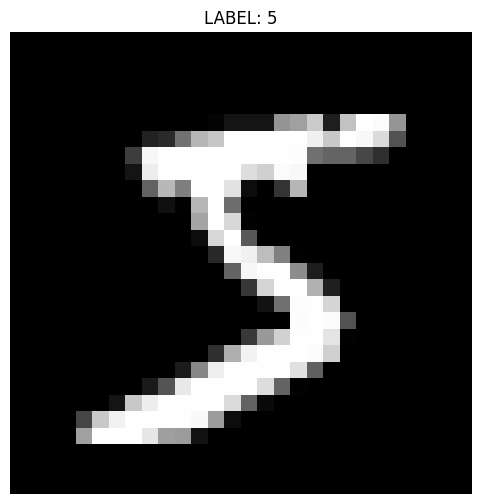

In [86]:
fig, ax = plt.subplots(figsize=(6, 6))
_ = ax.imshow(pil_image, cmap="Greys_r")
_ = ax.axis("off")
_ = ax.set_title(f"LABEL: {label}")
plt.show()

Or we can use [torchshow](https://github.com/xwying/torchshow). Be aware to convert the image to a `torch.Tensor` first. And scale the values between 0 and 1.
`torchshow` provides a convenient way to visualize tensors. It also allows for visualizing batches of images.

We use [torchvision.transforms.v2.functional](https://pytorch.org/vision/main/transforms.html#v2-api-reference-recommended) to convert a PIL image to a torch.Tensor.

This module contains many useful image processing functions.

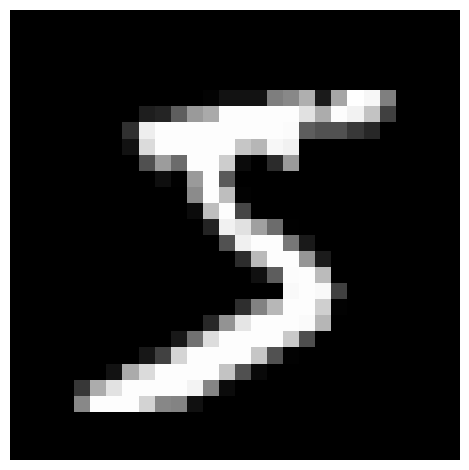

In [87]:
x = TF.to_image(pil_image).to(torch.float32) / 255.0
ts.show(x)

Now we want to look at multiple images, to get a feeling for the dataset.

Let's collect a couple of images. For convenience save them as tensors.

In [88]:
def get_images_from_ds(
    ds: torch.utils.data.Dataset, num_images_to_fetch: int = 16
) -> list[torch.Tensor]:
    """Fetch first n images from a torch.utils.data.Dataset with (image, label) signature."""
    # for each image: convert it to (N x C x H x W) format and scale to 0-1
    images = [
        TF.to_image(ds[i][0]).to(torch.float32).unsqueeze(0) / 255.0
        for i in range(0, num_images_to_fetch)
    ]
    return images


images = get_images_from_ds(ds_mnist_train, num_images_to_fetch=16)

A convenient way to display a grid of images is either `torchshow` or `torchvision.utils.make_grid`.

We create a batch of images by concatenating them into a tensor of (N x C x H x W).

**Note**: The most common way to organize images in PyTorch is the **NCHW** format, indicating the first dimension is the batch dimension, followed by the color channels, and height and width.

torch.Size([16, 1, 28, 28])

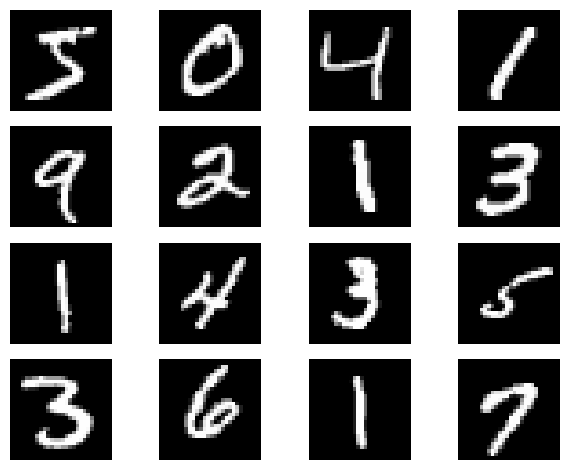

In [89]:
x_batch = torch.concat(images)
x_batch.shape
ts.show(x_batch)

Similarly we can create one big tensor with the images arranged in a grid and then visualize that using [torchvision.utils.make_grid](https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html).

This gives us more control on how we want to arrange the images (`nrow` is the number of images per row).

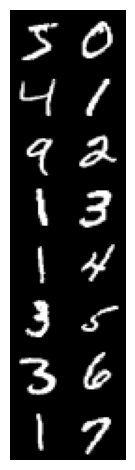

In [90]:
image_grid = make_grid(x_batch, nrow=2)
ts.show(image_grid)

**Extra Task**: Visualize the images with their label on top of it to inspect label noise / correctness.

You can use the following function to do the visualization.

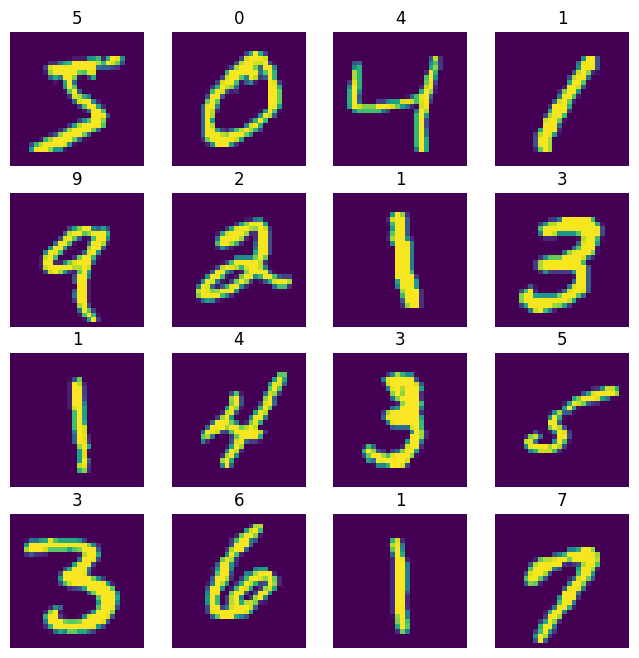

In [ ]:
import numpy as np


def plot_square_collage_with_captions(
    images: list[torch.Tensor], captions: list[str], caption_width: int = 30
):
    """Plot Square collage of images with captions on to of each image."""
    import math
    from textwrap import wrap

    num_images = len(images)
    side_length = math.ceil(math.sqrt(num_images))

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        ax = plt.subplot(side_length, side_length, i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, caption_width))
        plt.title(caption)
        pil_image = TF.to_pil_image(images[i])
        plt.imshow(pil_image)
        plt.axis("off")


labels = [str(ds_mnist_train[i][1]) for i in range(16)]
images = get_images_from_ds(ds_mnist_train)
x_batch = torch.concat(images)
plot_square_collage_with_captions(x_batch, labels)

**Extra Task**: Produce and inspect the distribution over the labels. This is important information and informs the whole modelling process.

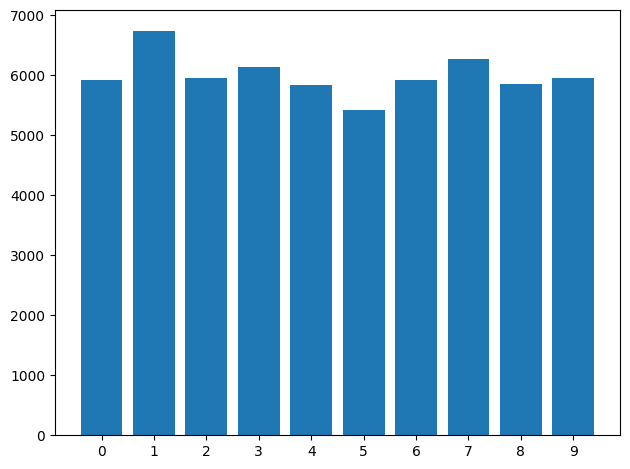

In [133]:
labels = ds_mnist_train.targets
values, counts = np.unique(labels, return_counts=True)
plt.xticks(values)
plt.bar(values, counts)
plt.tight_layout()
plt.show();

## 2) Data Transforms

We often need to transform / pre-process our data. 

For example, we might want to scale the data such that the mean is 0 and the standard deviation is 1, or we want to bring the data into the $[0,1]$ interval (by dividing by 255.).

Often we also want to apply `data augmentation` techniques to add more variation to our data.

**We will look into this topic more at a later stage.** Below a small examle.

Torchvision provides us with many options to implement transformations: [torchvision.transforms](https://pytorch.org/vision/main/transforms.html#)

Here is a small example:

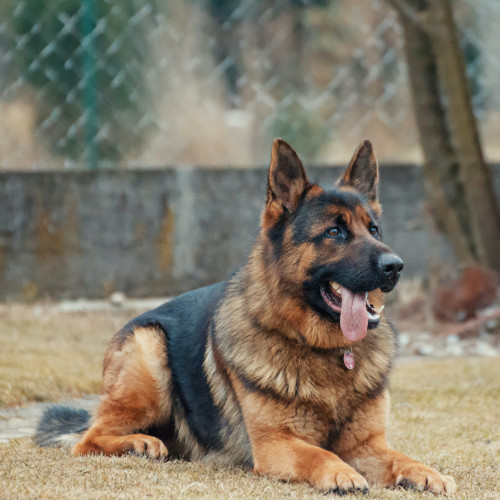

In [ ]:
url = "https://github.com/pytorch/vision/blob/main/gallery/assets/dog2.jpg?raw=true"
r = requests.get(url, allow_redirects=True)
image = Image.open(io.BytesIO(r.content))
image

Now we define a transformation pipeline with random components and see what happens.

In [ ]:
from torchvision import transforms

torch.manual_seed(123)

composed_transforms = transforms.Compose(
    [
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize((512, 512), antialias=True),
        transforms.ToTensor(),
    ]
)

num_examples = 16
images = list()
for i in range(0, num_examples):
    images.append(composed_transforms(image))

Now we visualize the effect of the transforms on the image.

torch.Size([16, 3, 512, 512])

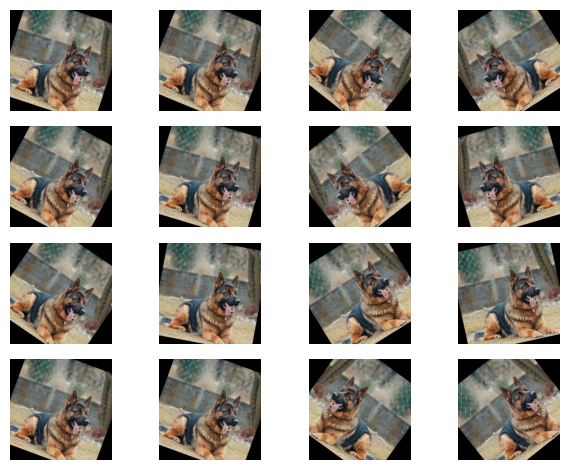

In [ ]:
images_batch = torch.stack(images, axis=0).to(torch.float32)
images_batch.shape
ts.show(images_batch)

**Task**: Play around with different versions of the `composed_transforms` object. You find inspiration here: [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html#).

A common operation is, e.g. a center crop.

## Data Loaders

To train models we need to define a pipeline that reads, transforms and batches images.

To achieve this we use the [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.

We can wrap a `torch.utils.data.Dataset` within a `torch.utils.data.DataLoader`.

Note the options: `batch_size`, `shuffle` and `num_workers` which are important.

In [134]:
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, batch_size=12, shuffle=True, num_workers=4
)

dl_mnist_test = torch.utils.data.DataLoader(
    ds_mnist_test, batch_size=12, shuffle=False, num_workers=4
)

In [135]:
# Let's check the first batch
try:
    images, labels = next(iter(dl_mnist_train))
except TypeError as e:
    print(f"Error occurred: {e}")

Error occurred: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bveri-exercises-hs2024\.venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bveri-exercises-hs2024\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bveri-exercises-hs2024\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bveri-exercis

**Question**: This does not work. Why?

**Answer**: The `Dataset` object returns `PIL.Image.Image` objects which can not be batched. We need to transform the images to tensors.


We can use the `torchvision.transforms` module for that.


`torchvision.datasets` offer a convenient way to apply transformations to images in a `Dataset` object.

In [ ]:
ds_mnist_train = torchvision.datasets.MNIST(
    root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor()
)
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, batch_size=12, shuffle=True, num_workers=4
)

Lets check if it worked.

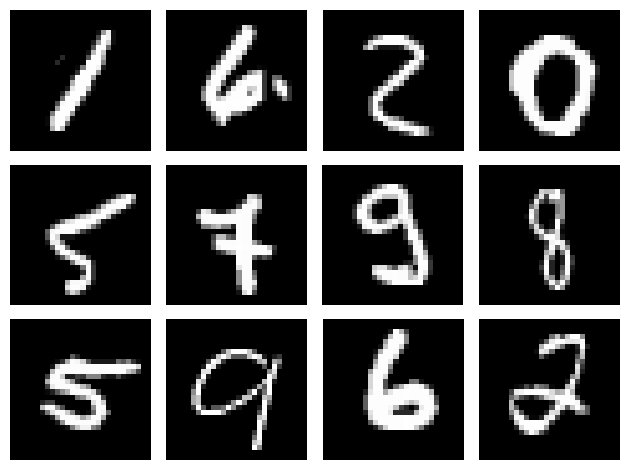

In [ ]:
# Let's check the first batch
try:
    images, labels = next(iter(dl_mnist_train))
except TypeError as e:
    print(f"Error occurred: {e}")
ts.show(images)

Great! We are have now a data pipeline which can be used in model training.

## 3) Network Definition

Now, that we have prepared our data: We want to model it. 

First, we need to define our model: Let's impement a shallow Multilayer-Perceptron.

We use the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class to define networks.

In [ ]:
class MLP(nn.Module):
    """A Multi-Layer Perceptron (MLP) model for classification."""

    def __init__(
        self,
        num_hidden: int,
        num_classes: int,
        input_size: tuple[int, int, int] = (1, 28, 28),
    ):
        """
        Args:
            num_hidden (int): Number of neurons in the hidden layer.
            num_classes (int): Number of output classes for classification.
            input_size tuple[int, int, int]: The dimensions of the input image.
        """
        super().__init__()
        # Flatten the input image into a 1D tensor
        # for example, from (1, 28, 28) to (784,)
        self.flatten = nn.Flatten()

        # Hidden layer: fully connected layer from input_size to num_hidden neurons.
        # No bias is used here (bias=False).
        self.hidden = nn.Linear(
            in_features=input_size[0] * input_size[1] * input_size[2],
            out_features=num_hidden,
            bias=False,
        )

        # Output layer: fully connected layer from num_hidden neurons to num_classes outputs.
        self.output = nn.Linear(in_features=num_hidden, out_features=num_classes)

    def forward(self, x):
        """
        Forward pass through the MLP model.

        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output logits (before softmax).
        """
        # Flatten the input tensor into (batch_size, input_size[0] * input_size[1])
        x = self.flatten(x)

        # Apply the hidden layer (linear transformation)
        x = self.hidden(x)

        # Apply ReLU activation function to introduce non-linearity
        x = F.relu(x)

        # Apply the output layer (linear transformation) to get the logits
        x = self.output(x)

        # Return the output logits (not yet passed through softmax)
        return x

Lets initialize the model and inspect it using `torchinfo`.

Note: We need to define the input shape.

In [ ]:
net = MLP(num_hidden=64, num_classes=10)
net = net.to(device)
print(net)
print(torchinfo.summary(net, input_size=(1, 1, 28, 28)))

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=64, bias=False)
  (output): Linear(in_features=64, out_features=10, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 64]                   50,176
├─Linear: 1-3                            [1, 10]                   650
Total params: 50,826
Trainable params: 50,826
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21


**Question**: How many parameters does the model have?

**Question**: How many would it have if there were only 5 classes? (`num_classes` from 10 to 5).

Let's check if the model works. E.g. if we can perform a forward pass.

In [ ]:
random_input = torch.randn(size=(1, 1, 28, 28)).to(device)

output = net(random_input)

output.shape

torch.Size([1, 10])

**Question**: What would be the output.shape if we change to `torch.randn(size=(5, 1, 28, 28))`?

**Question**: What would be the output.shape if we change to `torch.randn(size=(1, 3, 28, 28))`?

## 4) Model Training

We need different components to train a model:
- Loss function and optimizer
- Trainer: Iteration over training data and parameter updates
- Monitoring of the training process

### Loss Function & Optimizer

We need to define a loss function and an optimizer for the model which defines how the parameters are updated.

We use the Cross-Entropy Loss which is common for classification problems (more on that later)

To optimize the neural network weights we use the popular Adam optimizer with regularization (weight decay).

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-3)

### Training Loop

There are different ways to implement the training loop. 

It is typically a lot of boiler-plate code, thats why there are higher-level APIs such as:

- [lightning](https://lightning.ai/docs/pytorch/stable/)
- [Keras](https://keras.io/keras_3/)

And also use metrics tracker from libraries such as [torchmetrics](https://github.com/Lightning-AI/torchmetrics).

It is important to monitor training-progress. Thats why we calculate and print metrics.

We are, however, implementing the boiler plate below.

In [ ]:
torch.manual_seed(123)


def train_one_epoch(
    data_loader: torch.utils.data.DataLoader,
    net: torch.nn.Module,
    optimizer: torch.optim.Adam,
    loss_fn: Callable,
    device: str = "cpu",
    verbose: bool = True,
):

    net = net.to(device)

    with tqdm(data_loader, unit="batch", disable=not verbose) as tepoch:

        total_samples_seen = 0
        total_correct = 0

        for step, (X, y) in enumerate(tepoch):

            # Update Step
            logits = net(X.to(device))
            loss = loss_fn(logits, y.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate Accuracy
            class_probabilities = torch.softmax(logits, axis=-1).detach().cpu()
            y_hat = (
                class_probabilities.argmax(dim=1, keepdim=True).squeeze().detach().cpu()
            )

            num_correct = (y_hat == y).sum().item()
            num_samples = X.shape[0]
            batch_accuracy = num_correct / num_samples

            # Epoch Statistics
            total_samples_seen += num_samples
            total_correct += num_correct
            epoch_accuracy = total_correct / total_samples_seen

            if verbose:
                tepoch.set_postfix(
                    loss=loss.item(),
                    accuracy_batch=batch_accuracy,
                    accuracy_epoch=epoch_accuracy,
                )

In more complex setups one often creates a `Trainer` class which manages the training process. See [lightning.Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for an example.

### Optimization

Now we train our model for a few epochs.

We increase the batch_size to speed up the training.

We also normalize the input images to speed up convergence.

In [ ]:
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ]
)

ds_mnist_train = torchvision.datasets.MNIST(
    root=DATA_PATH, train=True, download=True, transform=image_transforms
)

torch.manual_seed(123)

dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

In [ ]:
total_epochs = 5
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_mnist_train, net, optimizer, loss_fn, device=device)

Starting Epoch: 1 / 5


  0%|          | 0/469 [00:00<?, ?batch/s]

Starting Epoch: 2 / 5


  0%|          | 0/469 [00:00<?, ?batch/s]

Starting Epoch: 3 / 5


  0%|          | 0/469 [00:00<?, ?batch/s]

Starting Epoch: 4 / 5


  0%|          | 0/469 [00:00<?, ?batch/s]

Starting Epoch: 5 / 5


  0%|          | 0/469 [00:00<?, ?batch/s]

Note the progress the model is making with respect to accuracy and the loss function value.

## 5) Evaluation

A very important part is model evaluation. We can not rely on the training scores for model evaluation since it might be too optimistic due to overfitting.

We evaluate our (best) model on the test set.

In [ ]:
def eval_loop(
    data_loader: torch.utils.data.DataLoader,
    net: torch.nn.Module,
    loss_fn: Callable,
    device: str = "cpu",
) -> tuple[float, torch.Tensor, torch.Tensor]:

    net = net.to(device)
    net.eval()
    with tqdm(data_loader, unit="batch") as tepoch:

        total_samples_seen = 0
        total_correct = 0

        y_list = list()
        y_hat_list = list()

        for step, (X, y) in enumerate(tepoch):

            # Forward Pass
            with torch.no_grad():
                logits = net(X.to(device))
            loss = loss_fn(logits, y.to(device))

            # Predictions
            class_probabilities = torch.softmax(logits, axis=-1).detach().cpu()
            y_hat = (
                class_probabilities.argmax(dim=1, keepdim=True).squeeze().detach().cpu()
            )

            # Metrics
            num_correct = (y_hat == y).sum().item()
            num_samples = X.shape[0]
            total_samples_seen += num_samples
            total_correct += num_correct
            epoch_accuracy = total_correct / total_samples_seen

            tepoch.set_postfix(
                loss=loss.item(),
                accuracy_epoch=epoch_accuracy,
            )

            # save preds and targets
            y_list.append(y.cpu())
            y_hat_list.append(y_hat.cpu())

    return epoch_accuracy, torch.concat(y_list), torch.concat(y_hat_list)

When testing and evaluating we need to apply exactly the same (static) transformations (not the data augmentation!) as when training the model.

In [ ]:
ds_mnist_test = torchvision.datasets.MNIST(
    root=DATA_PATH, train=False, download=True, transform=image_transforms
)
dl_mnist_test = torch.utils.data.DataLoader(
    ds_mnist_test, batch_size=128, shuffle=False, num_workers=4
)

test_accuracy, y, y_hat = eval_loop(dl_mnist_test, net, loss_fn, device=device)

print(f"Test Accuracy:  {test_accuracy:.3f}")

  0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy:  0.953


We also inspect the confusion matrix using the sklearn confusion matrix [Link](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html).

In [ ]:
cm = confusion_matrix(y, y_hat)

cm_display = ConfusionMatrixDisplay(cm)

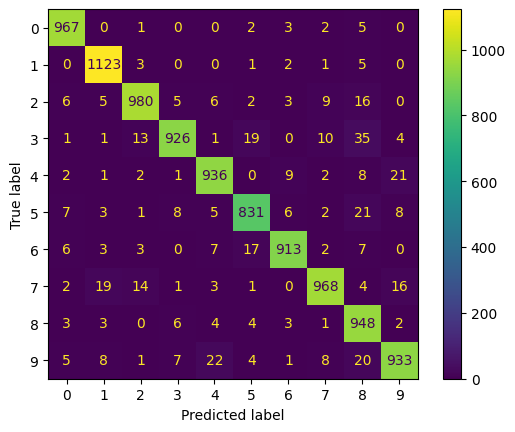

In [ ]:
cm_display.plot()